<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/diffusion2D_FipyFiniteVolume2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy, plotly-gif
# uncomment to install fipy, restart (runtime env.) and execute all

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# space discretization
from fipy import *

xL = yL = 0.
delX = delY = 1000.
xR, yR = xL+delX, yL+delY
dx = dy = 10.
nx, ny = int(delX/dx), int(delY/dy)
mesh = Grid2D(nx=nx, dx=dx, ny=ny, dy=dy) # todo: translate grid by (xL,yL)

print('xL = ', xL, ', xR = ', xR, ', dx = ', dx, ', nx = ', nx, '\n'
      'yL = ', yL, ', yR = ', yR, ', dy = ', dy, ', ny = ', ny, '\n'
      'cellsNbr = ', mesh.globalNumberOfCells)

xL =  0.0 , xR =  1000.0 , dx =  10.0 , nx =  100 
yL =  0.0 , yR =  1000.0 , dy =  10.0 , ny =  100 
cellsNbr =  10000


In [4]:
# time discretization
import numpy as np

tL = 0.0
delT = 5*60. # sec
tR = tL + delT

# diffusion-based time step size, dt
D = 20.
Fr = 0.5 # Fourier Number: Fr = D*dt/dx**2
dt = abs(Fr*dx**2/D)

nt = int(delT/dt)
t = np.linspace(tL, tR, nt+1)

print('tL = ', t[0], ', tR = ', t[-1], '\n'
      'D = ', D, ', Fr = ', Fr, '\n'
      'dt = Fr*dx**2/D = ', dt, ', nt = ', nt)

tL =  0.0 , tR =  300.0 
D =  20.0 , Fr =  0.5 
dt = Fr*dx**2/D =  2.5 , nt =  120


In [5]:
# defining the unkown's distribution
def distributionIn2D(x, y, zMin, zMax, xc, yc, width, isRectangular = True):
  if isRectangular:
    # rectangular distribuition
    return np.array([zMax if xc-width < xi
                     and xi < xc+width
                     and yc-width < yi
                     and yi < yc+width
                     else zMin
                     for xi in x
                     for yi in y])
  else:
    # Gaussian distribuition
    return zMin + zMax * np.exp(-((x-xc)**2+(y-yc)**2) / (2*width**2))

In [6]:
# initialization
zMin, zMax = 200, 1200
xc, yc, width = 250, 250, 40 # source epicenter and width

def initialize():
    # unkown's initialization
    global mesh, zMin, zMax, xc, yc, width, zInit, z
    zInitValue = distributionIn2D(x=mesh.x,
                                  y=mesh.y,
                                  zMin=zMin,
                                  zMax=zMax,
                                  xc=xc,
                                  yc=yc,
                                  width=width,
                                  isRectangular=False)
    zInit = CellVariable(mesh=mesh, value=zInitValue)
    z = CellVariable(mesh=mesh, value=zInit)

    # Imposing noFlow BC
    z.faceGrad.constrain((0,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global D, eq
    eq = (TransientTerm(coeff=1.0)
       == DiffusionTerm(coeff=D))

initialize()

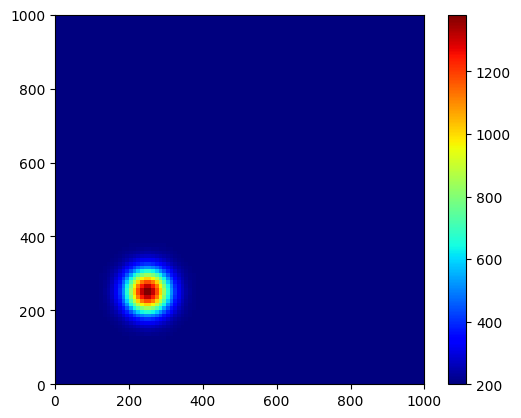

In [7]:
# ploting the unkown's initial distribution
viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-.1,
                datamax = zInit.max()+.1)
viewer.plot()

In [8]:
# defining contour lines distribution
from scipy.interpolate import griddata
import plotly.graph_objects as go

xr = np.linspace(xL, xR, nx)
yr = np.linspace(yL, yR, ny)
[X, Y] = np.meshgrid(xr, yr)

def goFigure(z, title_text, ncontours=6):
    global mesh, xr, yr, X, Y

    # computing z values at the rigular grid vertices by interpolation
    Z = griddata((mesh.x, mesh.y), z, (X, Y) , method='linear')

    # plot parameters
    ZOffset = 0.1
    start, end = np.nanmin(Z)+ZOffset, np.nanmax(Z)-ZOffset
    size = np.rint((end-start)/(ncontours*50))*50

    # plot data
    data = go.Contour(x=xr, y=yr, z=Z,
                      colorscale='Jet', contours=dict(start=start,
                                                      end=end,
                                                      size=size,
                                                      coloring='fill'))
    fig = go.Figure(dict({"data": data,
                          "layout": {"title": {"text": title_text},
                                     "title_x":0.5,
                                     "width":500, "height":500}}))
    return fig

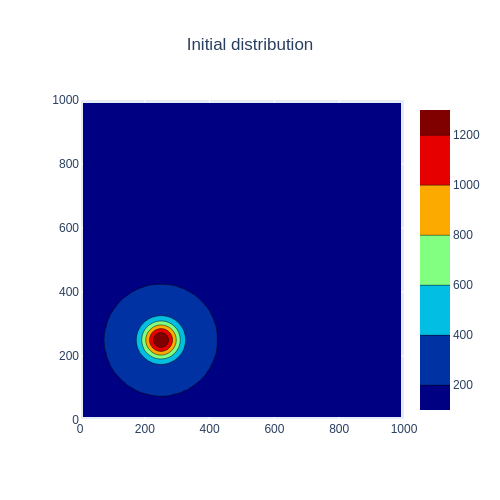

In [9]:
# plotting contour lines for zInit
from IPython.display import Image

title_text = 'Initial distribution'
fig = goFigure(z=zInit, title_text=title_text)

pngFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/diffusion2D_zInit_Fipy.png'
fig.write_image(pngFileName)

# displaying the image
Image(open(pngFileName,'rb').read())

In [10]:
# defining the time-step update function

def diffuse1(z, dt):
    eq.solve(var=z, dt=dt)

In [11]:
# definig the time instants for the saving of y

savingFreq = 4
delIdx = int(len(t)/savingFreq)
save_times = t[range(0, len(t), delIdx)]

closest_idx = lambda val, arr: np.abs(arr - val).argmin()
save_indices = [closest_idx(save_time, t) for save_time in save_times]

print('save_times = ', save_times, '\n'
      'save_indices = ', save_indices)

save_times =  [  0.  75. 150. 225. 300.] 
save_indices =  [0, 30, 60, 90, 120]


In [12]:
# Loop over time, calculate z(t,x,y) and save it at save_times
import pandas as pd

# create a pandas data frame  to save data
df = pd.DataFrame(data={'x':mesh.x, 'y':mesh.y})

# initialize zr (z values at regular grid vertices)
zr = zInit

# define time's and df column's names upon time value
tiSTR = lambda ti: str(round(ti,3))
zrColumnName = lambda ti: f'zr_{tiSTR(ti)}'

# iterate over time
for i, ti in enumerate(t):
    if i in save_indices:
        df[zrColumnName(ti)] = z
    diffuse1(z, Fr)

# display dataframe head
df.head(3)

,x,y,zr_0.0,zr_75.0,zr_150.0,zr_225.0,zr_300.0
0,5.0,5.0,200.0,200.0,200.000002,200.000050,200.000522
1,15.0,5.0,200.0,200.0,200.000003,200.000072,200.000692
2,25.0,5.0,200.0,200.0,200.000006,200.000123,200.001069


After 300.0  (sec)


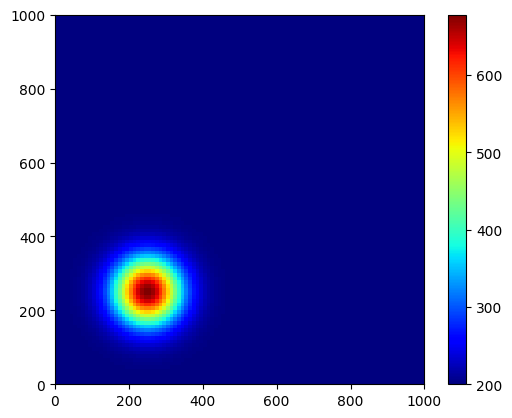

In [13]:
# ploting the unkown's final distribution
print('After', dt*nt, ' (sec)')
viewer = Viewer(vars = (z),
                datamin = z.min()-.1,
                datamax = z.max()+.1)
viewer.plot()

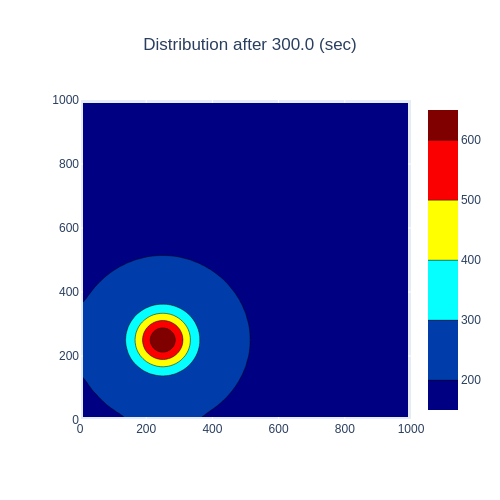

In [14]:
# plotting contour lines for the unkown's final distribution
title_text = 'Distribution after '+str(round(dt*nt,3))+' (sec)'
fig = goFigure(z=z, title_text=title_text)

pngFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/diffusion2D_z_Fipy.png'
fig.write_image(pngFileName)

# displaying the image
Image(open(pngFileName,'rb').read())

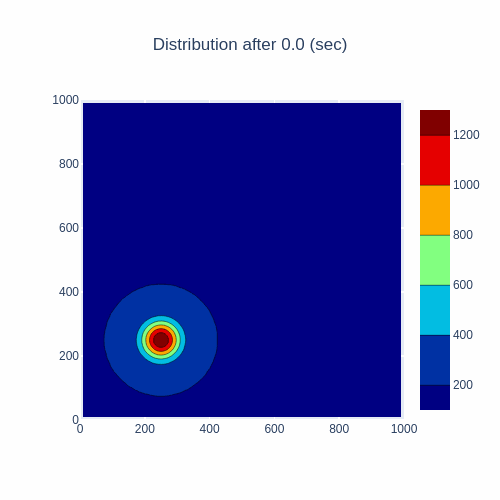

In [15]:
import plotly.graph_objs as go
from plotly_gif import GIF, capture

# defining a frame
def frame_(ti):
    return goFigure(z=df[zrColumnName(ti)],
                    title_text='Distribution after '+str(round(ti,3))+' (sec)')

# making list of frames
frames = []
for ti in save_times:
    frames.append(frame_(ti))

# making the animation as a gif file
gifFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/diffusion2D_Fipy.gif'
gif = GIF(mode="png", gif_name=gifFileName, verbose=True)
[gif.create_image(frame) for frame in frames]
gif.create_gif()

# displaying the animation
Image(open(gifFileName,'rb').read())